In [60]:
from __future__ import print_function
import tensorflow as tf

import matplotlib.pyplot as plt

from keras.preprocessing.image import load_img, save_img, img_to_array
import numpy as np
from scipy.optimize import fmin_l_bfgs_b
import time
import argparse

from keras.applications import vgg19
from keras import backend as K


#args = parser.parse_args()
base_image_path = 'content_images/rick-and-morty.jpg'
style_reference_image_path = 'style_images/picasso.jpg'

# dimensions of the generated picture.
width, height = load_img(base_image_path).size
img_nrows = 800
img_ncols = int(width * img_nrows / height)

def preprocess_image(image_path):
    img = load_img(image_path, target_size=(img_nrows, img_ncols))
    img = img_to_array(img)
    
    img = np.expand_dims(img, axis=0)
    img = vgg19.preprocess_input(img)
    return img

# util function to convert a tensor into a valid image


def deprocess_image(x):
    if K.image_data_format() == 'channels_first':
        x = x.reshape((3, img_nrows, img_ncols))
        x = x.transpose((1, 2, 0))
    else:
        x = x.reshape((img_nrows, img_ncols, 3))
    # Remove zero-center by mean pixel
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    # 'BGR'->'RGB'
    x = x[:, :, ::-1]
    x = np.clip(x, 0, 255).astype('uint8')
    return x


style_reference_image = K.variable(preprocess_image(style_reference_image_path))
#result_prefix = 'test'
#iterations = 100

# these are the weights of the different loss components
total_variation_weight = 1.0
style_weight = 10.0
content_weight = 1.0

# util function to open, resize and format pictures into appropriate tensors



In [61]:
#prepare input
base_image = K.variable(preprocess_image(base_image_path))
style_reference_image = K.variable(preprocess_image(style_reference_image_path))
channels = 3


In [62]:
# get tensor representations of our images

def prepare_input(base_image):
    
    # this will contain our generated image
    if K.image_data_format() == 'channels_first':
        combination_image = K.placeholder((1, 3, img_nrows, img_ncols))
    else:
        combination_image = K.placeholder((1, img_nrows, img_ncols, 3))

    # combine the 3 images into a single Keras tensor
    input_tensor = K.concatenate([base_image,
                                  style_reference_image,
                                  combination_image], axis=0)
    return combination_image, input_tensor


# build the VGG19 network with our 3 images as input
# the model will be loaded with pre-trained ImageNet weights
combination_image, input_tensor = prepare_input(base_image)
model = vgg19.VGG19(input_tensor=input_tensor,
                    weights='imagenet', include_top=False)
print('Model loaded.')

# get the symbolic outputs of each "key" layer (we gave them unique names).
outputs_dict = dict([(layer.name, layer.output) for layer in model.layers])



Model loaded.


In [63]:
def gram_matrix(x):
    assert K.ndim(x) == 3
    if K.image_data_format() == 'channels_first':
        features = K.batch_flatten(x)
    else:
        features = K.batch_flatten(K.permute_dimensions(x, (2, 0, 1)))
    gram = K.dot(features, K.transpose(features))
    return gram


def style_loss(style, combination):
    assert K.ndim(style) == 3
    assert K.ndim(combination) == 3
    S = gram_matrix(style)
    C = gram_matrix(combination)
    channels = 3
    size = img_nrows * img_ncols
    return K.sum(K.square(S - C)) / (4.0 * (channels ** 2) * (size ** 2))

def content_loss(base, combination):
    
    channels = 3
    size = img_nrows * img_ncols
    return K.sum(K.square(combination - base))/(2.0 * channels *size)


def total_variation_loss(x):
    assert K.ndim(x) == 4
    channels = 3
    size = img_nrows * img_ncols
    if K.image_data_format() == 'channels_first':
        a = K.square(
            x[:, :, :img_nrows - 1, :img_ncols - 1] - x[:, :, 1:, :img_ncols - 1])
        b = K.square(
            x[:, :, :img_nrows - 1, :img_ncols - 1] - x[:, :, :img_nrows - 1, 1:])
    else:
        a = K.square(
            x[:, :img_nrows - 1, :img_ncols - 1, :] - x[:, 1:, :img_ncols - 1, :])
        b = K.square(
            x[:, :img_nrows - 1, :img_ncols - 1, :] - x[:, :img_nrows - 1, 1:, :])
    return K.sum(K.pow(a + b, 1.25))/(2.0 * channels *size)

In [64]:
# combine these loss functions into a single scalar

feature_layers = ['block1_conv1', 'block2_conv1',
                  'block3_conv1', 'block4_conv1',
                  'block5_conv1']

def get_output(combination_image):
    """
    calculate loss
    """
    loss = K.variable(0.0)
    layer_features = outputs_dict['block5_conv2']
    base_image_features = layer_features[0, :, :, :]
    combination_features = layer_features[2, :, :, :]
    loss = loss + content_weight * content_loss(base_image_features,
                                                combination_features)

    
    for layer_name in feature_layers:
        layer_features = outputs_dict[layer_name]
        style_reference_features = layer_features[1, :, :, :]
        combination_features = layer_features[2, :, :, :]
        sl = style_loss(style_reference_features, combination_features)
        loss = loss + (style_weight / len(feature_layers)) * sl
    loss = loss + total_variation_weight * total_variation_loss(combination_image)

    # get the gradients of the generated image wrt the loss
    grads = K.gradients(loss, combination_image)
    outputs = [loss]

    if isinstance(grads, (list, tuple)):
        outputs += grads
    else:
        outputs.append(grads)

    f_outputs = K.function([combination_image], outputs)

    return f_outputs, outputs

f_outputs, outputs = get_output(combination_image)



In [65]:
def eval_loss_and_grads(x):
    
    if K.image_data_format() == 'channels_first':
        x = x.reshape((1, 3, img_nrows, img_ncols))
    else:
        x = x.reshape((1, img_nrows, img_ncols, 3))
    #combination_image, input_tensor = prepare_input(base_image_path)
    
    outs = f_outputs([x])
    loss_value = outs[0]
    if len(outs[1:]) == 1:
        grad_values = outs[1].flatten().astype('float64')
    else:
        grad_values = np.array(outs[1:]).flatten().astype('float64')
    return loss_value, grad_values


class Evaluator(object):

    def __init__(self):
        self.loss_value = None
        self.grads_values = None

    def loss(self, x):
        assert self.loss_value is None
        loss_value, grad_values = eval_loss_and_grads(x)
        self.loss_value = loss_value
        self.grad_values = grad_values
        return self.loss_value

    def grads(self, x):
        assert self.loss_value is not None
        grad_values = np.copy(self.grad_values)
        self.loss_value = None
        self.grad_values = None
        return grad_values



In [66]:
def train():
    evaluator = Evaluator()

    x = preprocess_image(base_image_path)
    #print(evaluator.loss,evaluator.grads)

    for i in range(iterations):
        print('iteration', i)
        start_time = time.time()
        x, min_val, _ = fmin_l_bfgs_b(evaluator.loss, x.flatten(),\
                                         fprime=evaluator.grads, maxfun=20)
        print('Current loss value:', min_val)
        end_time = time.time()
        print('duration:',end_time- start_time )
        
    img = deprocess_image(x.copy())
    plt.imshow(img)
    return evaluator, img
  

In [ ]:
x = preprocess_image(base_image_path)
iterations = 10
evaluator, x = train()
#img = deprocess_image(x.astype('float64'))
from PIL import Image
img = Image.fromarray(x, 'RGB')
#img.resize((600,600))
img.save('output_images/picasso_RM.png')

iteration 0
Current loss value: 33601047000.0
duration: 14.724857568740845
iteration 1
Current loss value: 19346720000.0
duration: 12.339817762374878
iteration 2
Current loss value: 13360500000.0
duration: 13.169535398483276
iteration 3
Current loss value: 10387630000.0
duration: 13.236307621002197
iteration 4
Current loss value: 8746331000.0
duration: 13.42179799079895
iteration 5
Current loss value: 7658226700.0
duration: 13.298723459243774
iteration 6
Current loss value: 6857014300.0
duration: 13.175172328948975
iteration 7
Current loss value: 6253772000.0
duration: 12.93966031074524
iteration 8
Current loss value: 5775914000.0
duration: 13.591663837432861
iteration 9
Current loss value: 5352846300.0
duration: 13.66471266746521


### Drop

In [18]:
fname = result_prefix +'art_iter10.png'
save_img(fname, x)

In [13]:
evaluator = Evaluator()
iterations = 100
for i in range(iterations):
    print('iteration', i)
    start_time = time.time()
    x, min_val, _ = fmin_l_bfgs_b(evaluator.loss, x.flatten(),\
                                         fprime=evaluator.grads, maxfun=20)
    print('Current loss value:', min_val)
    end_time = time.time()
    print('duration:',end_time- start_time )

iteration 0
Current loss value: 6121187000.0
duration: 114.20600581169128
iteration 1
Current loss value: 2320239600.0
duration: 112.07391381263733
iteration 2
Current loss value: 1483462000.0
duration: 113.61913776397705
iteration 3
Current loss value: 1137276200.0
duration: 116.44068789482117
iteration 4
Current loss value: 952240900.0
duration: 117.22123408317566
iteration 5
Current loss value: 823956700.0
duration: 120.21681308746338
iteration 6
Current loss value: 735034900.0
duration: 126.65213799476624
iteration 7
Current loss value: 645414500.0
duration: 122.34628105163574
iteration 8
Current loss value: 577038300.0
duration: 123.24067211151123
iteration 9
Current loss value: 529368030.0
duration: 124.32972002029419
iteration 10
Current loss value: 478234530.0
duration: 129.73897314071655
iteration 11
Current loss value: 442810270.0
duration: 117.12570476531982
iteration 12
Current loss value: 413920670.0
duration: 119.3126289844513
iteration 13
Current loss value: 380489800.0


KeyboardInterrupt: 

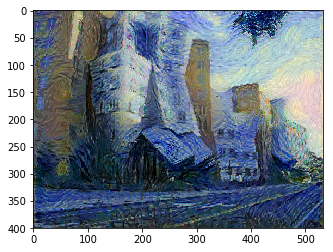

In [105]:
img = deprocess_image(x.copy())
plt.imshow(img)

# Video transfer

In [ ]:
cap = cv2.VideoCapture('input_video.avi')
frame_width = int(cap.get(3))
frame_height = int(cap.get(4)) 
# Check if camera opened successfully
if (cap.isOpened() == False): 
    print("Unable to read camera feed")
    
count = 0 
#fourcc = cv2.VideoWriter_fourcc('M','J','P','G')
#out = cv2.VideoWriter('outpy.avi',fourcc,20.0,(224,224))


while(cap.isOpened()):
    ret, frame = cap.read()
    if ret is False:
        break
    print(str(count)+'th frame processing')
    
    base_image, style_reference_image,combination_image, input_tensor = \
    prepare_input(base_image_path)
    model = vgg19.VGG19(input_tensor=input_tensor,
                    weights='imagenet', include_top=False)
    
    
    
    #cv2.imshow('output',frame)
    #out.write(final_img)
    filename ="style_images/frame%d.jpg" % count;count+=1 
    cv2.imwrite(filename, final_img)